# Kanapy – Generation of voxelized RVE
Generate a representation volume element (RVE) for a synthetic microstructure and export geometry as Abaqus INP file. Generate orientation for each grain in form of Euler angles that are characteristic for a given crystallographic texture.


Author: Alexander Hartmaier, ICAMS / Ruhr-University Bochum, Germany<br>
January 2023

### 0. Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kanapy as knpy
from math import pi
if int(knpy.__version__[0]) < 6 or int(knpy.__version__[2]) < 1:
    raise ModuleNotFoundError(f'Kanapy version 6.1. or higher is required. Current version is {knpy.__version__}. Please update Kanapy')
knpy.__version__

'6.1.2'

### 1. Create geometric representation of microstructure
Using the `Microstructure` class of Kanapy, a microstructure object is generated, by passing the microstructure descriptors 'ms_elong' as input data to this class. The Python dictionary 'ms_elong' also contains the geometrical definition of the RVE box. After this, the method `plot_stats_init()` plots the statistical distributions that will be used for the particle simulation. Then, the method `init_RVE()` creates the particle set that fulfills the required size distribution within the given lower (dashed vertical line) and upper (solid vertical line) bound.  
In the second step, the particle simulation is performed by invoking the method `pack()`. To accomplish this, the particles generated in the last step are initally downscaled in size by a factor of 100 such that they can move freely through the simulation box but still fulfill the same charactistics of the size distribution with larger and smaller particles in the desired quantities. To avoid overlap of particles, collsions are considered. In this way, the particles form a realistic distribution within the space of the simulation box, as can be verified in the plot by `plot_ellipsoids()`.  
After the generation of the particle distribution of the desired volume fraction statistical distribution of particles, the method `voxelize()` generates a voxelated structure in form of a regular 3D mesh of the simulation box. Each voxel lying inside a WC particle will be assigned to this phase, all remaining voxels will be considered as Co binder phase. The desired volume fraction of the majority phase WC is provided as argument 'vf'. This procedure generates a representative volume element (RVE) of the cemented carbide, where the WC and Co phase have approximately the experimental volume fractions and a realistic size distribution of the WC particles. In the figure, created by the `plot_voxels()` method, the individual grains are represented in arbitrary colors.  
The grain geometry in the voxelized 3D microstructure (representative volume element, RVE) will be analysed statistically with respect to the grain size distribution and the aspect ratio distribution. This is accomplished by running the `generate_grains()` method of the microstructure object, which performs a Delaunay tesseleation of the voxel structure by which a ployhedral hull around each grain is constructed and and analyzed with respect to grain size and aspect ratio. The results are plotted with the `plot_stats()` method.  


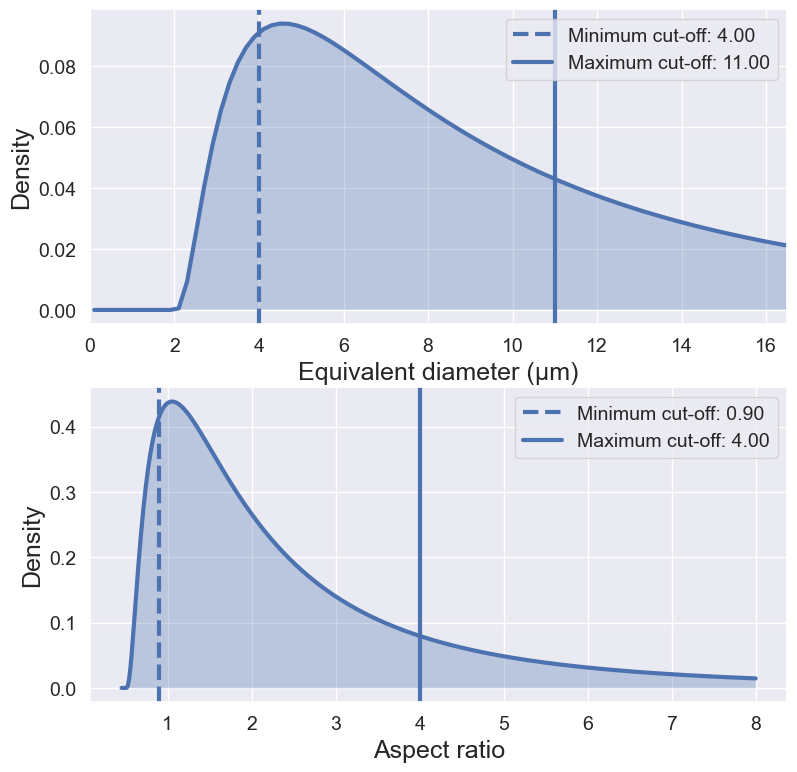

Creating an RVE based on user defined statistics
    Analyzed statistical data for phase Austenite (0)
    Total number of particles  = 29
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (20, 20, 20) (mm)
    Number of voxels (X, Y, Z) = (15, 15, 15)
    Voxel resolution (X, Y, Z) = [1.3333 1.3333 1.3333](mm)
    Total number of voxels     = 3375


Considered phases (volume fraction): 
0: Austenite (100.0%)


Starting particle simulation
    Creating particles from distribution statistics
    Particle packing by growth simulation


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:11<00:00, 58.51it/s]


Completed particle packing
110 overlapping particles detected after packing
Kinetic energy of particles after packing: 4.034308432880864
Initial kinetic energy: 4.034308432880864



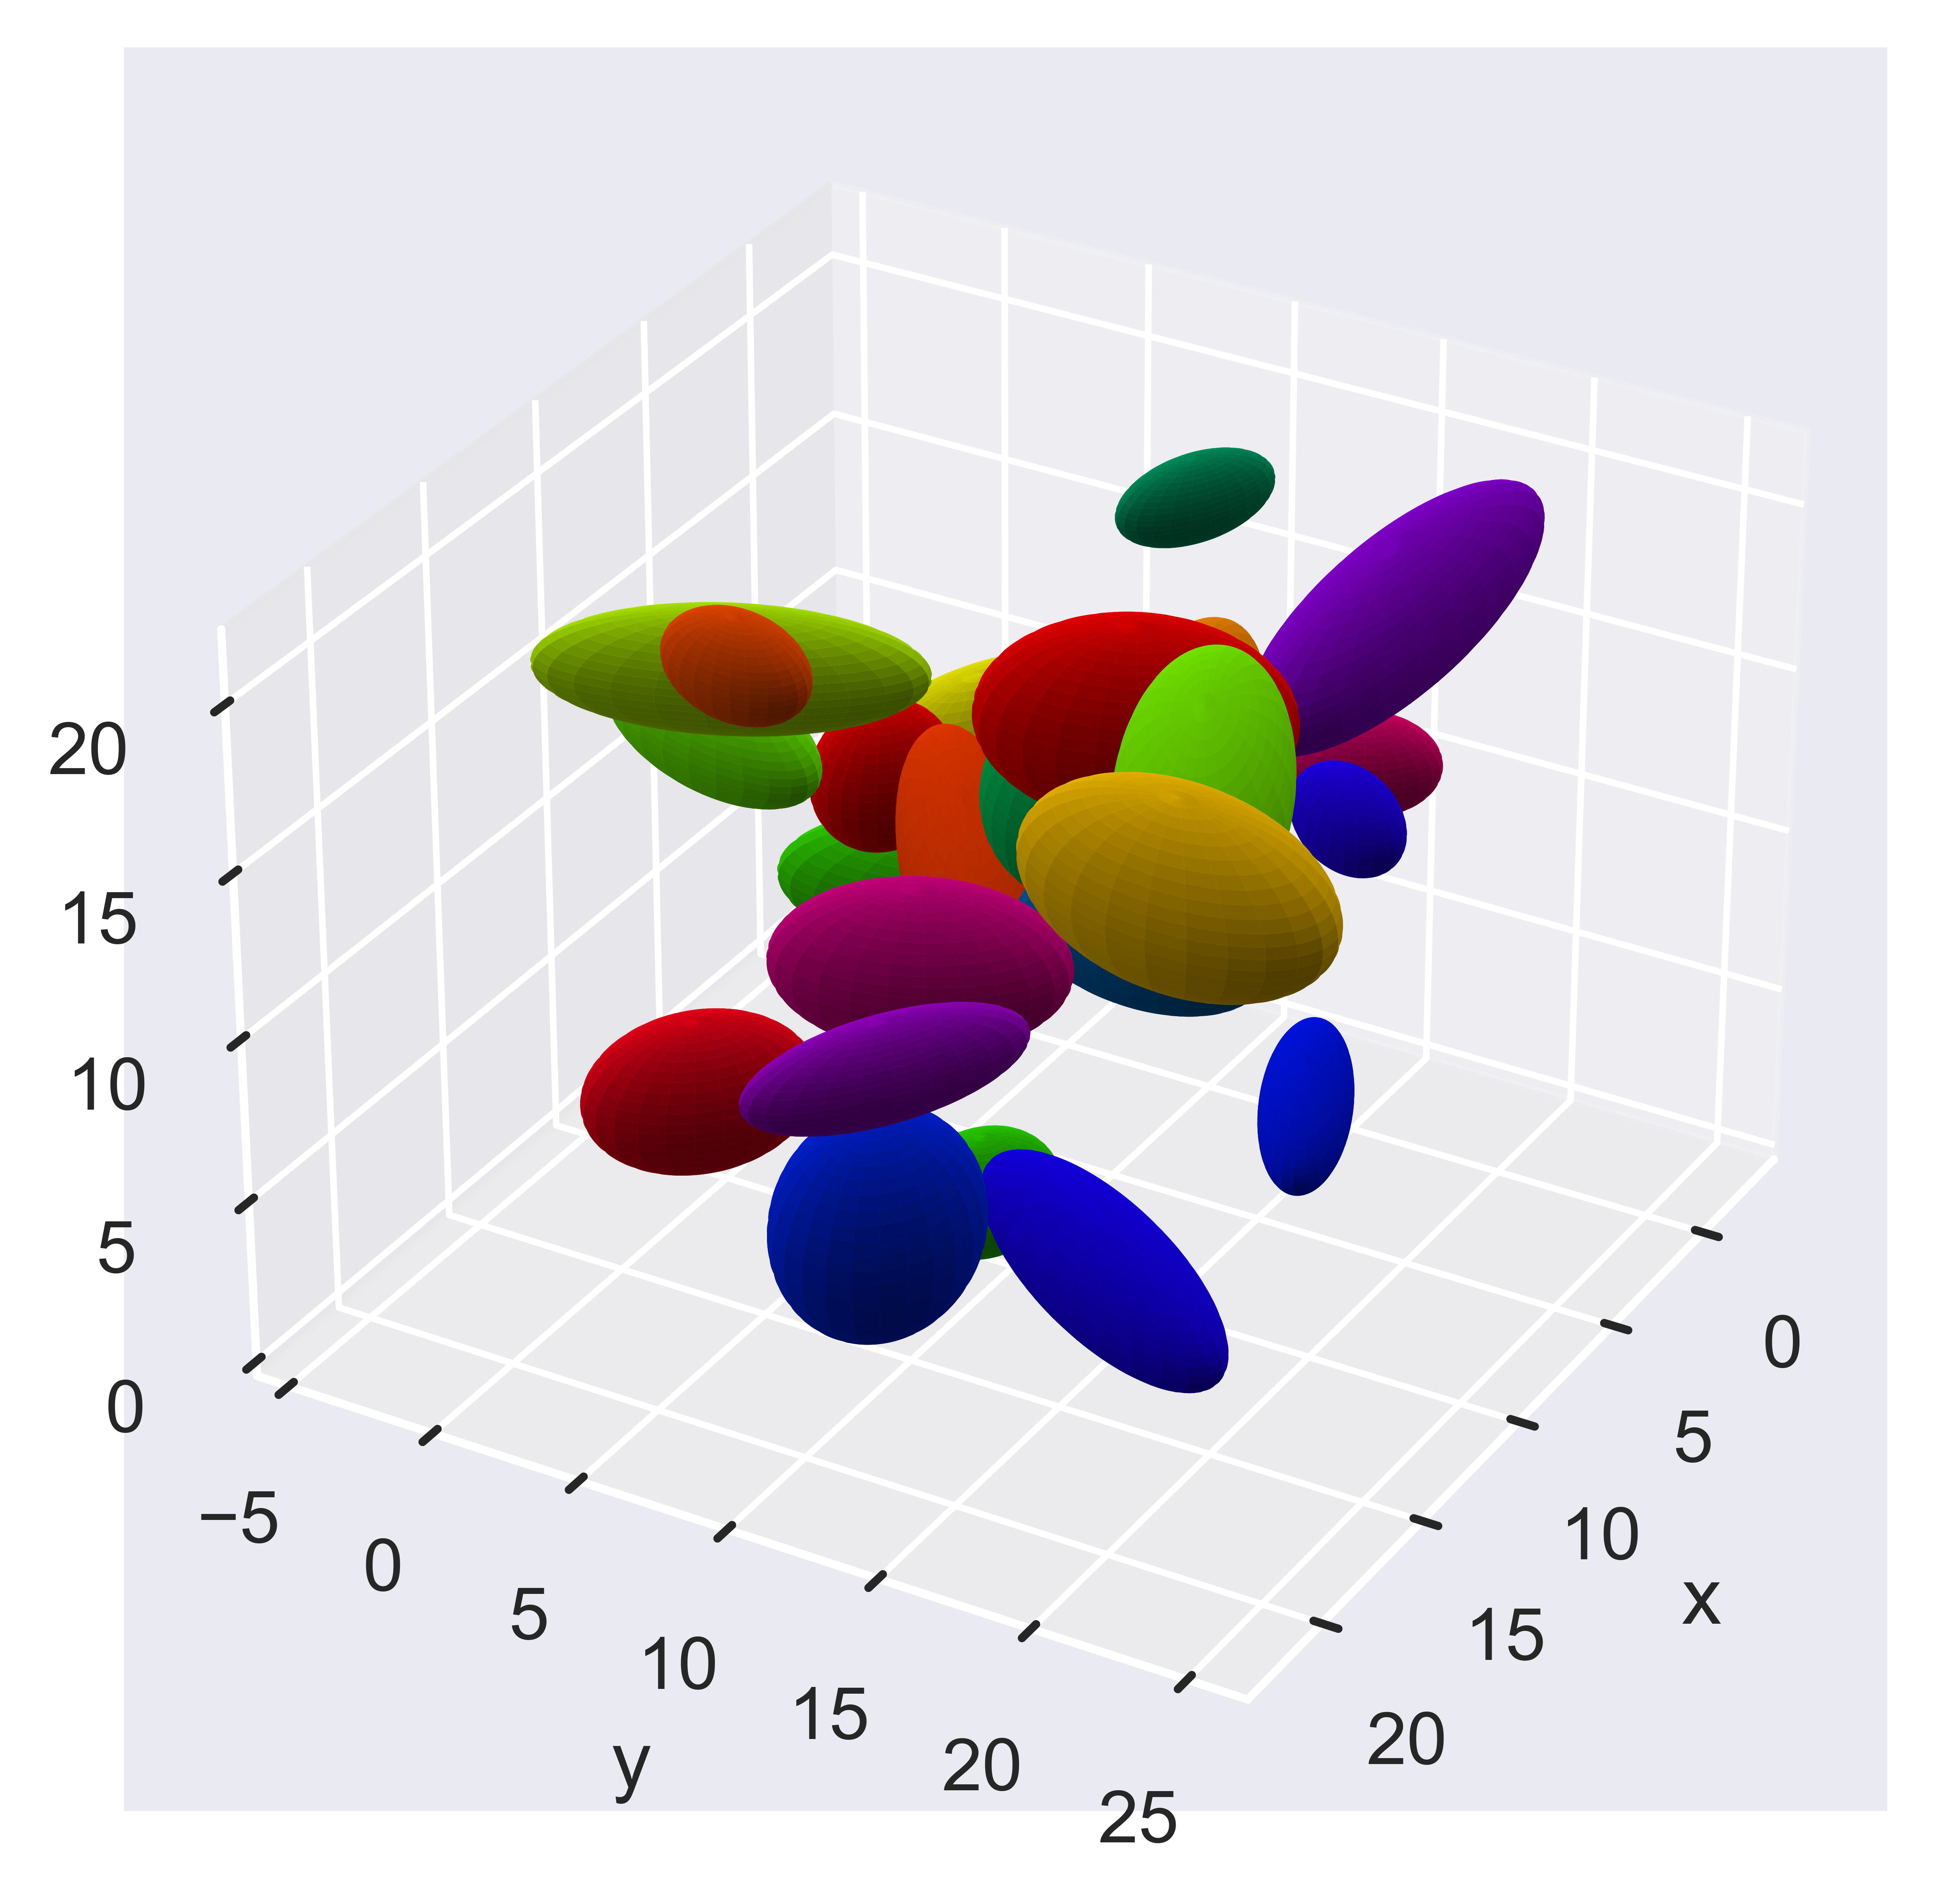

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:00<00:00, 2657363.62it/s]


Completed RVE voxelization



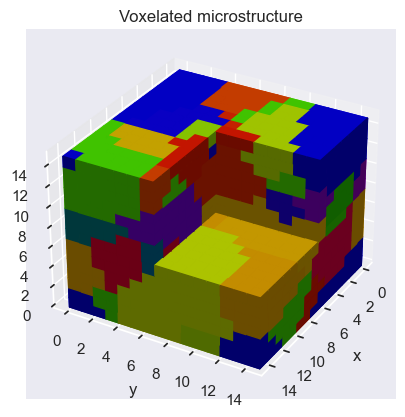


Generated Delaunay tesselation of grain vertices.
Assigning 726 tetrahedra to grains ...


726it [00:12, 57.87it/s] 


Finished generating polyhedral hulls for grains.
Total volume of RVE: 8000 mm^3
Total volume of polyhedral grains: 8000.0 mm^3
Mean relative error of polyhedral vs. voxel volume of individual grains: 0.22
for mean volume of grains: 275.862 mm^3.

Computing the L1-error between input and output diameter distributions.
    L1 error phase 0 between particle and grain geometries: 0.62069
Plotting input & output statistics for phase 0


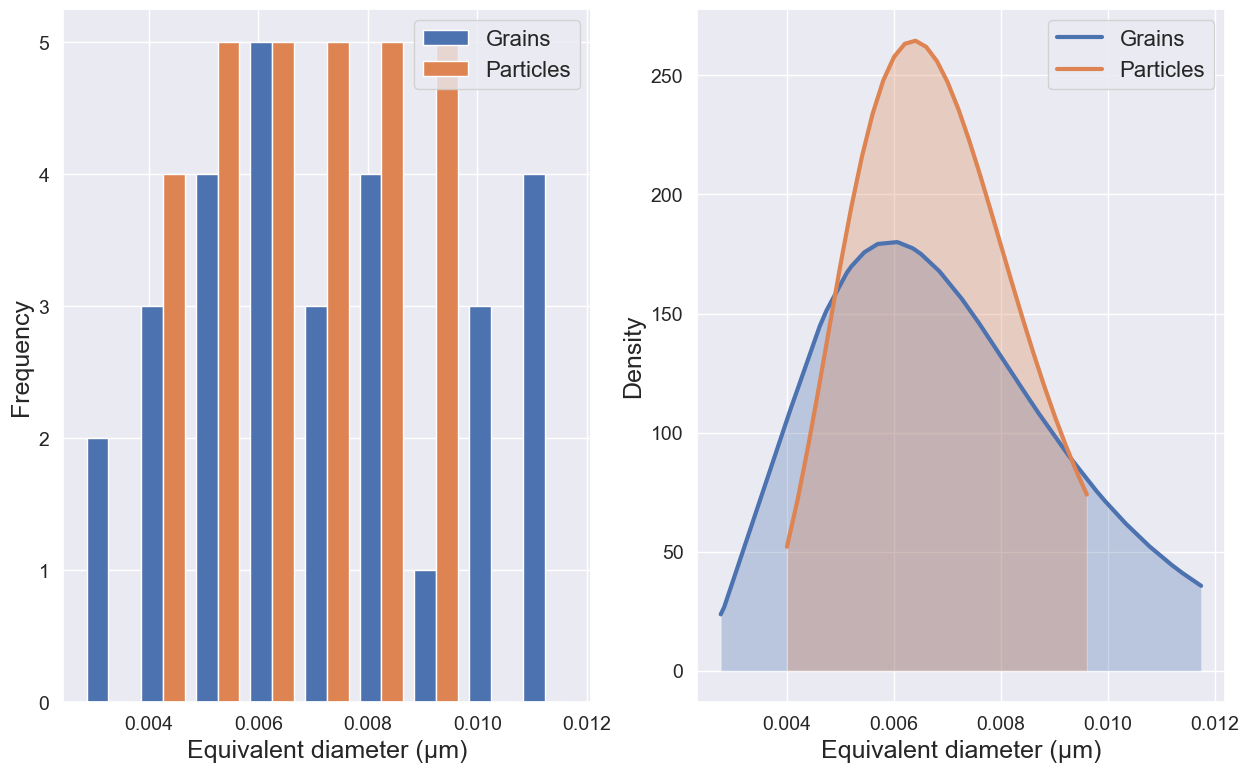

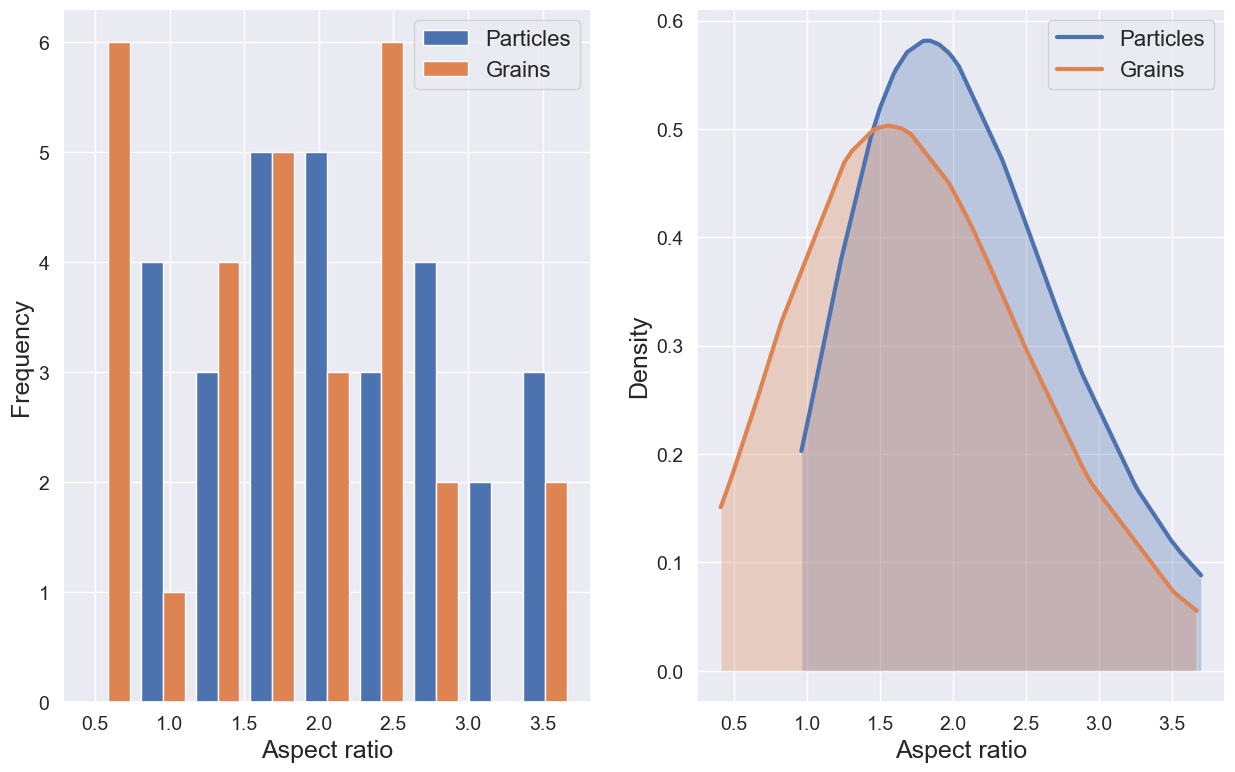

In [2]:
# Basic material definitions
matname = 'Austenite fcc'
matnumber = 4  # UMAT number for fcc Iron
deg = pi/180.0

# RVE and microstructure paramaters
Nv = 15  # number of voxels
size = 20  # size of RVE
periodic = True
ms_elong = {'Grain type': 'Elongated',
          'Equivalent diameter': {'sig': 1.0, 'scale': 7.0, 'loc': 2.0, 'cutoff_min': 4.0, 'cutoff_max': 11.0},
          'Aspect ratio': {'sig':1.0, 'scale': 1.5, 'loc': 0.5, 'cutoff_min': 0.9, 'cutoff_max': 4.0},
          'Tilt angle': {'kappa': 2.*deg, 'loc': 90.*deg, "cutoff_min": 0.0, "cutoff_max": 180.0*deg},
          'RVE': {'sideX': size, 'sideY':size, 'sideZ': size, 'Nx': Nv, 'Ny': Nv, 'Nz': Nv, 'ialloy': matnumber},
          'Simulation': {'periodicity': str(periodic), 'output_units': 'mm'},
          'Phase': {'Name': 'Austenite', 'Number': matnumber, 'Volume fraction': 1.0}}

ms = knpy.Microstructure(ms_elong)
ms.plot_stats_init()
ms.init_RVE()
ms.pack()
ms.plot_ellipsoids()
ms.voxelize()
ms.plot_voxels()
ms.generate_grains()
ms.plot_stats()

### 1.1 Alternatively load voxel file

JSON files with voxel structures can be imported instead of RVE generation.

In [ ]:
ms = knpy.import_voxels('filename')
ms.generate_grains()
ms.plot_stats()

### 2. Generate set of grain orientations for specified texture
The grain orientations are generated with the method `ms.generate_orientations()` as specified by the parameter 'tdesc', which is either 'unimodal' in which case a (list of) Euler angles and a kernal halwidth must be provided. If tdesc=='random', a random texture will be generated. The required grain boundary texture is defined as histogram.

In [3]:
texture = 'goss' # Implemented textures are goss, copper, random
mdf = 'high'
if knpy.MTEX_AVAIL:
    # define standard parameters for misorientation distribution functions
    """Test cases for misorientation distribution (MDF) adapted from
    Miodownik, M., et al. "On boundary misorientation distribution functions
    and how to incorporate them into three-dimensional models of microstructural
    evolution." Acta materialia 47.9 (1999): 2661-2668.
    https://doi.org/10.1016/S1359-6454(99)00137-8
    """
    mdf_freq = {
      "high": [0.0013303016, 0.208758929, 0.3783092708, 0.7575794912, 1.6903069613,
               2.5798481069, 5.0380640643, 10.4289690569, 21.892113657, 21.0,
               22.1246762077, 13.9000439533],
      "low":  [4.5317, 18.6383, 25, 20.755, 12.5984, 7.2646, 4.2648, 3.0372, 2.5,
               1, 0.31, 0.1],
      "random": [0.1, 0.67, 1.9, 3.65, 5.8, 8.8, 11.5, 15.5, 20, 16.7, 11.18, 4.2]
    }
    mdf_bins = np.linspace(62.8/12,62.8,12)

    # generate grain orientations and write ang file
    """
    Different textures can be choosen and assinged to the RVE geometry that has
    been defined above.
    Texture is defined by the orientation of the ideal component in Euler space
    ang and a kernel halfwidth omega. Kernel used here is deLaValleePoussin.
    The function createOriset will first create an artificial EBSD by sampling
    a large number of discrete orientations from the ODF defined by ang and
    omega. Then a reduction method is applied to reconstruct this initial ODF
    with a smaller number of discrete orientations Ngr. The reduced set of
    orientations is returned by the function.
    For more information on the method see:
    https://doi.org/10.1107/S1600576719017138
    """
    if texture == 'goss':
        ang = [0, 45, 0]    # Euler angle for Goss texture
        omega = 7.5         # kernel half-width
        tdesc = 'unimodal'
    elif texture == 'copper':
        ang = [90, 35, 45]
        omega = 7.5
        tdesc = 'unimodal'
    elif texture == 'random':
        ang = None
        omega = None
        tdesc = 'random'
    else:
        raise ValueError('texture not defined. Take goss, copper or random')
    ms.generate_orientations(tdesc, ang=ang, omega=omega, 
                             hist=mdf_freq[mdf], Nbase=1000)


I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  .... done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 

time =

   19.0981


e =

   49.7774


e =

   49.7764


e =

   49.7721


e =

   49.7431


e =

   49.7280


e =

   49.7222


e =

   49.7159


e =

   49.6909


e =

   49.6878


e =

   49.6749


e =

   49.6509


e =

   49.6483


e =

   49.6412


e =

   49.6409


e =

   49.6135


e =

   49.5836


e =

   49.5680


e =

   49.5636


e =

   49.5610


e =

   49.5574


e =

   49.5480


e =

   49.5382


e =

   49.5072


e =

   49.5071


time =

    5.2089



### 3. Write Abaqus input deck
The geometrical information of the RVE is exported as Abaqus input file with the ending "_geom.inp" by the method `write_abq()`. This input deck defines a finite element for each voxel. Furthermore, for each grain a set of elements is defined and assigned to a user defined material with the name "GRAIN{grain_id}_MAT". By the same method, the information on the grain orientations is exported as Abaqus input file with the ending "_mat.inp". This file contains the information on the material number to be used in the ICAMS Crystal Plasticity UMAT and the Euler angles for each grain, identified by the name "GRAIN{grain_id}_MAT". The _geom.inp file contains an *INCLUDE command to read the material definitions in the _mat.inp file.

In [4]:
# write Abaqus input file for voxelated geometry (_geom.inp) and Euler angles (_mat.inp)
ptag = 'pbc' if periodic else 'no_pbc'
fname = ms.write_abq(nodes='v', file=f'abq{Nv}_gr{ms.Ngr}_{ptag}_geom.inp')


Writing RVE as ABAQUS file "./abq15_gr29_pbc_geom.inp"
Using brick element type C3D8.
---->DONE!



### 3.1 Export voxel file
With the method `write_voxels()` the information about geometry of the voxel structure and the grain orientations are written into a JSON file, which can be re-imported into Kanapy to safe the packing and voxelization steps, as demonstrated above.

In [5]:
# Save Kanapy microstructure as voxel file
ms.write_voxels(script_name='generate_rve.ipynb', mesh=False, system=False)

Writing voxel information of microstructure to ./px_29grains_voxels.json.
